In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### Load Dataset and quick checkups

In [3]:
DS_PATH = "Mall_Customers.csv"


In [4]:
df = pd.read_csv(DS_PATH)

In [4]:
df.shape

(200, 5)

In [5]:
df.dtypes

CustomerID                 int64
Genre                     object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [6]:
df.isna().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

### Clean and Standardize Column Names:

In [5]:
#Standardize
def normalize_col(c):
    return (
        str(c)
        .strip()
        .lower()
        .replace(" ", "_")
        .replace("-", "_")
        .replace("(", "")
        .replace(")", "")
        .replace("$", "s")
        .replace("/", "_")
    )

original_cols = df.columns.tolist()
df.columns = [normalize_col(c) for c in df.columns]

##### Our dataset uses 'genre' by mistake, map to gender:

In [6]:
df.columns = [c.replace("genre", "gender") for c in df.columns]

print("Original columns:", original_cols)
print("Normalized columns:", df.columns.tolist())

Original columns: ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
Normalized columns: ['customerid', 'gender', 'age', 'annual_income_ks', 'spending_score_1_100']


##### Drop duplicate rows (if any)

In [7]:
before = len(df)
df = df.drop_duplicates().copy()
after = len(df)
if before != after:
    print(f"Removed {before - after} duplicate rows.")

### Identify Key Columns:

In [8]:
def find_col(cols, keywords):
    for c in cols:
        s = c.lower()
        if all(k in s for k in keywords):
            return c
    return None

cols = df.columns.tolist()
age_col = find_col(cols, ["age"])
income_col = find_col(cols, ["income"]) or find_col(cols, ["annual", "income"])
spend_col = find_col(cols, ["spending", "score"]) or find_col(cols, ["spending"])
gender_col = find_col(cols, ["gender"])  # optional
id_col = find_col(cols, ["customer", "id"]) or find_col(cols, ["id"])

print("Detected columns:")
print("  age     ->", age_col)
print("  income  ->", income_col)
print("  spend   ->", spend_col)
print("  gender  ->", gender_col)
print("  id      ->", id_col)

# Minimal check
needed = [age_col, income_col, spend_col]
if any(c is None for c in needed):
    raise ValueError("Could not auto-detect one of [age, income, spending]. Please rename columns or set manually.")


Detected columns:
  age     -> age
  income  -> annual_income_ks
  spend   -> spending_score_1_100
  gender  -> gender
  id      -> customerid


### Now we encode gender:

In [9]:
if gender_col is not None:
    if df[gender_col].dtype == object:
        # Map by first letter
        df[gender_col] = df[gender_col].astype(str).str.strip().str[0].str.upper().map({"M":1, "F":0})
        df[gender_col] = df[gender_col].fillna(-1)
    else:
        # Assume already numeric
        df[gender_col] = df[gender_col].fillna(-1)

## Feature Matrix & Scale:

In [11]:
feature_cols = [age_col, income_col, spend_col, gender_col]

In [12]:
X = df[feature_cols].to_numpy().astype(float)

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
print("Feature columns:", feature_cols)
print("Scaled X shape:", X_scaled.shape)

Feature columns: ['age', 'annual_income_ks', 'spending_score_1_100', 'gender']
Scaled X shape: (200, 4)


## Exploratory Data Analysis:

### Histograms:

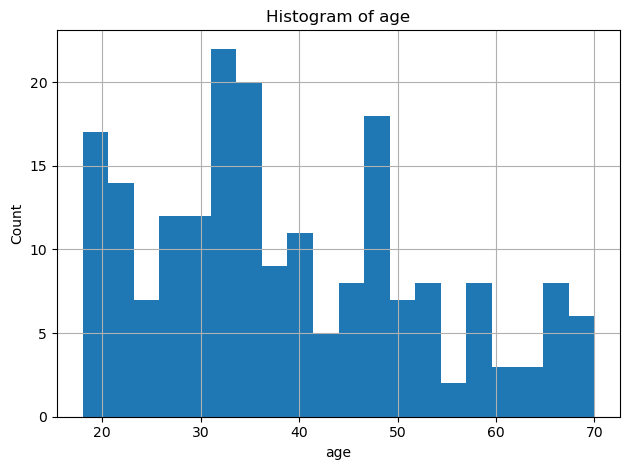

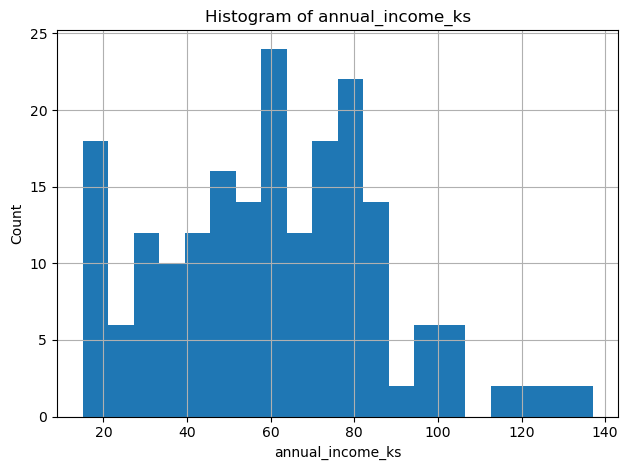

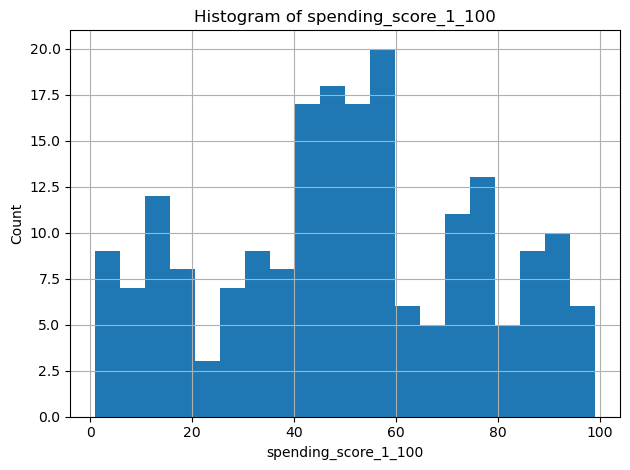

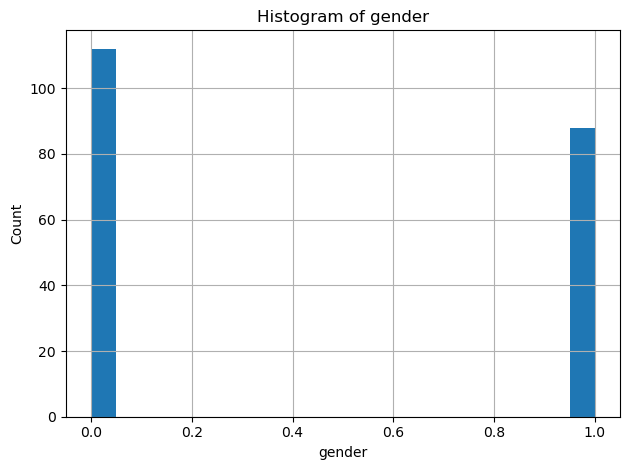

In [15]:
for col in feature_cols:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

### Pairwise Scatters:

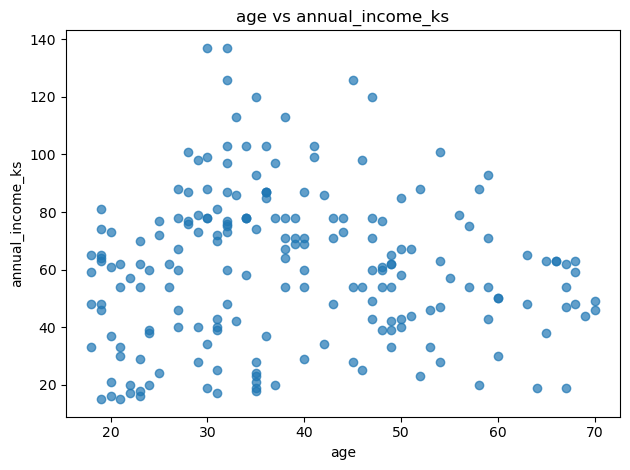

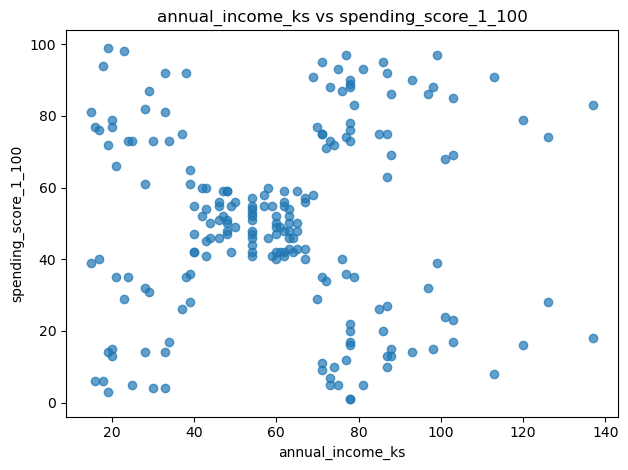

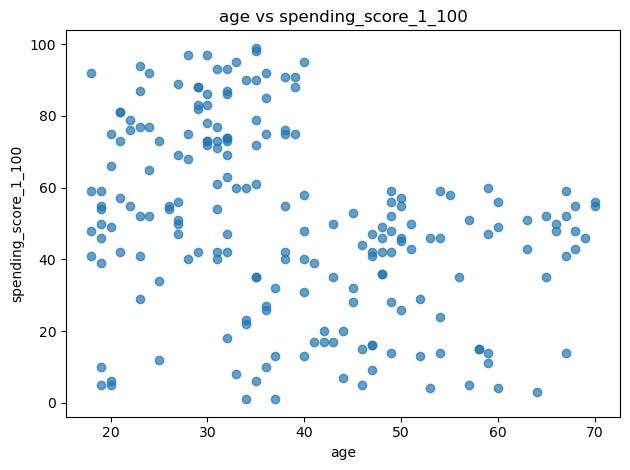

In [16]:
pairs = [(age_col, income_col), (income_col, spend_col), (age_col, spend_col)]
for xcol, ycol in pairs:
    plt.figure()
    plt.scatter(df[xcol], df[ycol], alpha=0.7)
    plt.title(f"{xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

## K(Elbow + Silhouette):

In [17]:
k_range = range(2, 11)
inertias = []
silhouettes = []

# Reproducibility
SEED = 42
np.random.seed(SEED)

In [18]:

k_range = range(2, 11)
inertias = []
silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))


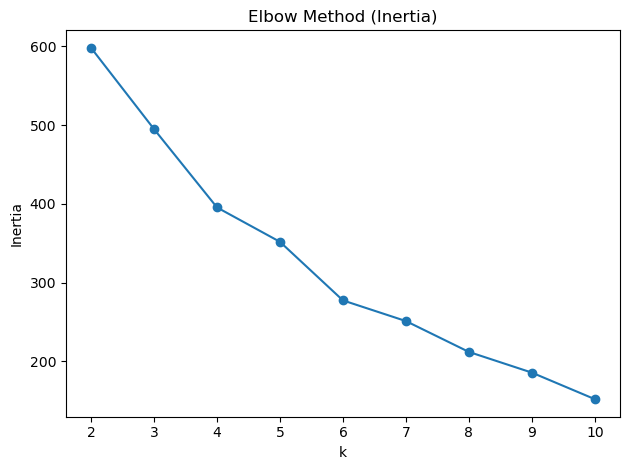

In [19]:
# Plot elbow (inertia)
plt.figure()
plt.plot(list(k_range), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

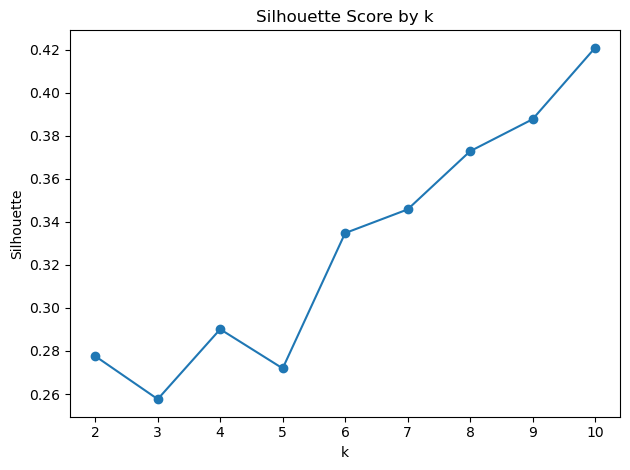

In [20]:
# Plot silhouette
plt.figure()
plt.plot(list(k_range), silhouettes, marker="o")
plt.title("Silhouette Score by k")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.tight_layout()
plt.show()

In [21]:
best_k_sil = int(k_range[int(np.argmax(silhouettes))])
print("Best k by silhouette:", best_k_sil)

Best k by silhouette: 10


In [22]:
BEST_K = best_k_sil

We'll use silhouette's best k

## Fit K-Means & visualize clusters:

In [23]:
km = KMeans(n_clusters=BEST_K, random_state=SEED, n_init="auto")
labels = km.fit_predict(X_scaled)
df["cluster"] = labels

back to original scale:

In [24]:
centroids = scaler.inverse_transform(km.cluster_centers_)

In [25]:
print("Cluster sizes:")
print(pd.Series(labels).value_counts().sort_index())

Cluster sizes:
0    26
1    24
2    14
3    21
4    26
5    19
6    25
7    18
8    13
9    14
Name: count, dtype: int64


### Visualize clusters in 2D

##### Automate all pairwise combinations:

In [26]:
from itertools import combinations

feature_cols_plus_gender = [age_col, income_col, spend_col, gender_col]
pairs = list(combinations(feature_cols_plus_gender, 2))

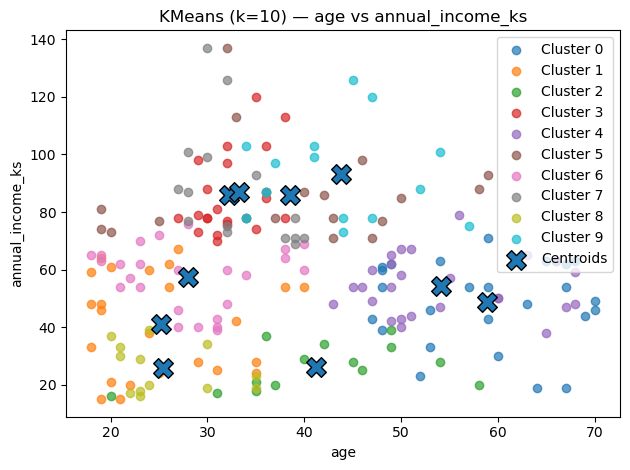

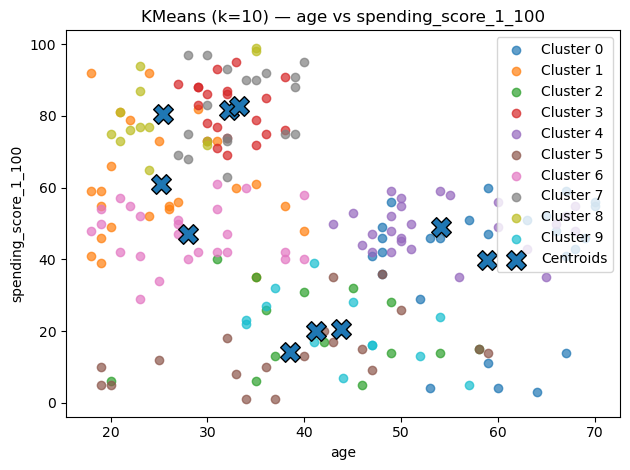

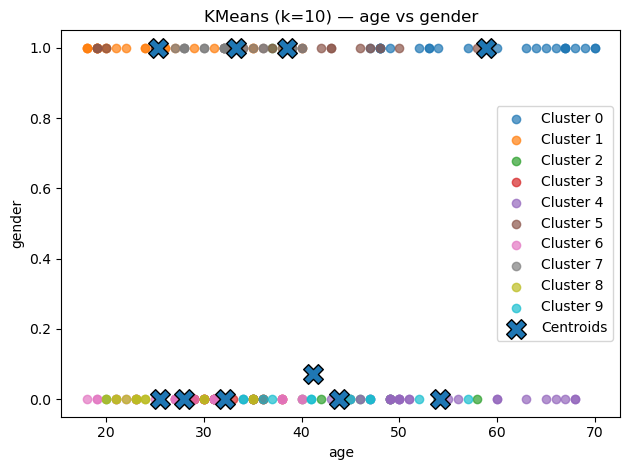

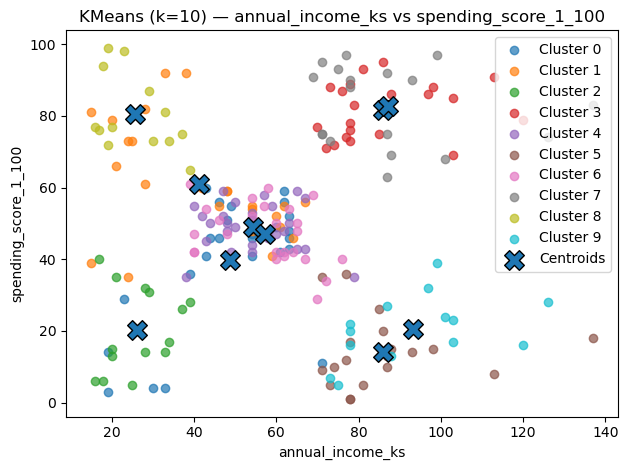

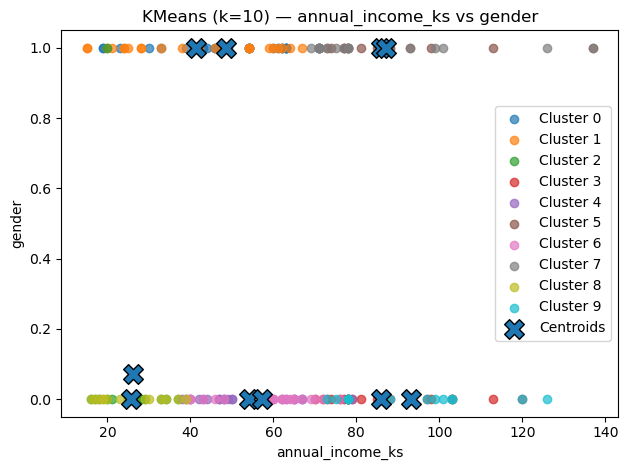

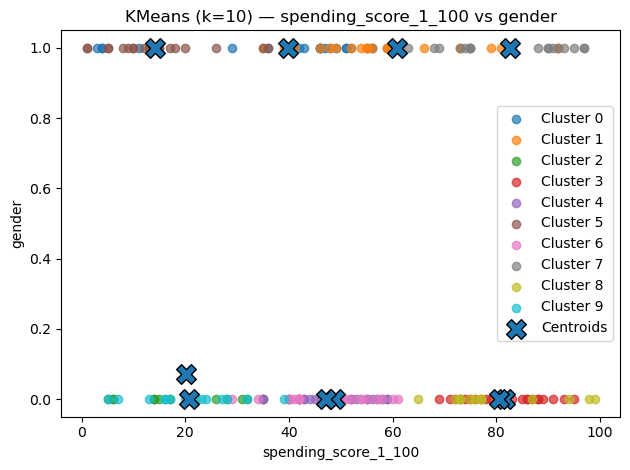

In [27]:
for xcol, ycol in pairs:
    plt.figure()
    for cl in np.unique(labels):
        mask = labels == cl
        plt.scatter(df.loc[mask, xcol], df.loc[mask, ycol], alpha=0.7, label=f"Cluster {cl}")
    # Plot centroids (converted to original scale)
    # Map centroid columns to indices in feature_cols
    x_idx = feature_cols.index(xcol)
    y_idx = feature_cols.index(ycol)
    plt.scatter(centroids[:, x_idx], centroids[:, y_idx], marker="X", s=200, edgecolor="k", label="Centroids")
    plt.title(f"KMeans (k={BEST_K}) — {xcol} vs {ycol}")
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Cluster profiling:

In [28]:
profile_cols = feature_cols.copy()

summary = df.groupby("cluster")[profile_cols].agg(["mean","median","min","max","count"])
display(summary)

age                      annual_income_ks                  \
              mean median min max count             mean median min  max   
cluster                                                                    
0        58.846154   59.0  47  70    26        48.692308   51.5  19   71   
1        25.250000   24.0  18  40    24        41.250000   44.0  15   67   
2        41.214286   41.0  20  58    14        26.071429   26.5  16   39   
3        32.190476   32.0  27  38    21        86.047619   79.0  70  120   
4        54.153846   50.5  43  68    26        54.230769   54.0  38   79   
5        38.473684   40.0  19  59    19        85.894737   81.0  71  137   
6        27.960000   27.0  18  40    25        57.360000   60.0  39   76   
7        33.277778   32.0  27  40    18        87.111111   82.5  69  137   
8        25.461538   23.0  20  35    13        25.692308   23.0  16   39   
9        43.785714   44.0  34  57    14        93.285714   92.5  73  126   

              spending_score_1_100                         gender             \
        count                 mean median min max count      mean median min   
cluster                                                                        
0          26            39.846154   46.0   3  60    26  1.000000    1.0   1   
1          24            60.916667   57.5  35  92    24  1.000000    1.0   1   
2          14            20.142857   16.0   5  40    14  0.071429    0.0   0   
3          21            81.666667   83.0  69  95    21  0.000000    0.0   0   
4          26            48.961538   49.5  35  59    26  0.000000    0.0   0   
5          19            14.210526   13.0   1  36    19  1.000000    1.0   1   
6          25            47.120000   47.0  29  61    25  0.000000    0.0   0   
7          18            82.666667   85.5  63  97    18  1.000000    1.0   1   
8          13            80.538462   77.0  65  99    13  0.000000    0.0   0   
9          14            20.642857   21.0   5  39    14  0.000000    0.0   0   

                   
        max count  
cluster            
0         1    26  
1         1    24  
2         1    14  
3         0    21  
4         0    26  
5         1    19  
6         0    25  
7         1    18  
8         0    13  
9         0    14

### Average Spending per cluster:

In [29]:
avg_spend = df.groupby("cluster")[spend_col].mean().sort_values(ascending=False)
print("\nAverage spending score per cluster:")
print(avg_spend)



Average spending score per cluster:
cluster
7    82.666667
3    81.666667
8    80.538462
1    60.916667
4    48.961538
6    47.120000
0    39.846154
9    20.642857
2    20.142857
5    14.210526
Name: spending_score_1_100, dtype: float64


### Now we Visualize:

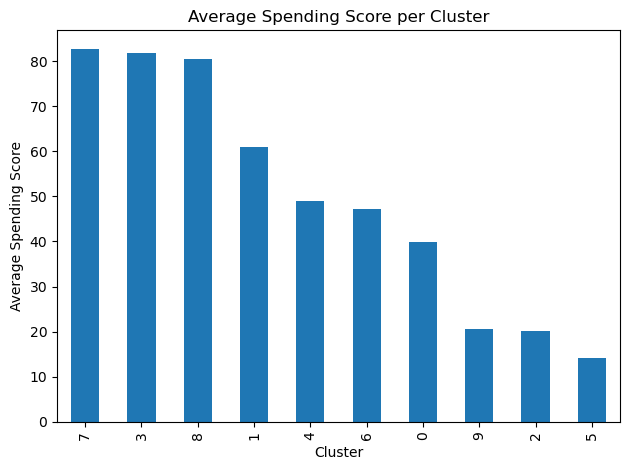

In [30]:
plt.figure()
avg_spend.plot(kind="bar")
plt.title("Average Spending Score per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Spending Score")
plt.tight_layout()
plt.show()

Now we can see:

1. High spenders → Clusters 7, 3, 8 (avg ~80+) show the highest spending behavior → most valuable customer segments.
2. Moderate spenders → Clusters 1, 4, 6, 0 (avg ~40–61) → could be nurtured into high spenders with targeted promotions.
3. Low spenders → Clusters 9, 2, 5 (avg ~14–20) → least profitable group, price-sensitive or low-engagement customers.

## DBSCAN:

In [31]:
# Simple grid search for DBSCAN over eps and min_samples
eps_grid = np.linspace(0.3, 1.5, 9)   # tweak if needed
min_samples_grid = [3, 4, 5, 6, 8, 10]

In [32]:
best_score = -1
best_params = None
best_labels = None

In [33]:
for eps in eps_grid:
    for ms in min_samples_grid:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels_db = db.fit_predict(X_scaled)
        # silhouette requires at least 2 clusters and no all -1
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        if n_clusters >= 2 and np.unique(labels_db).size > 1 and np.any(labels_db != -1):
            try:
                score = silhouette_score(X_scaled, labels_db)
            except Exception:
                score = -1
            if score > best_score:
                best_score = score
                best_params = (eps, ms)
                best_labels = labels_db

print("Best DBSCAN silhouette:", best_score)
print("Best params (eps, min_samples):", best_params)

Best DBSCAN silhouette: 0.2776035125578273
Best params (eps, min_samples): (np.float64(1.2), 3)


### 2D plots for DBSCAN on the same pairs

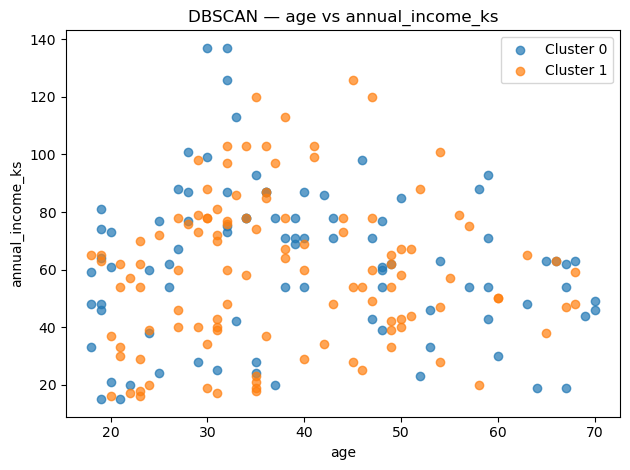

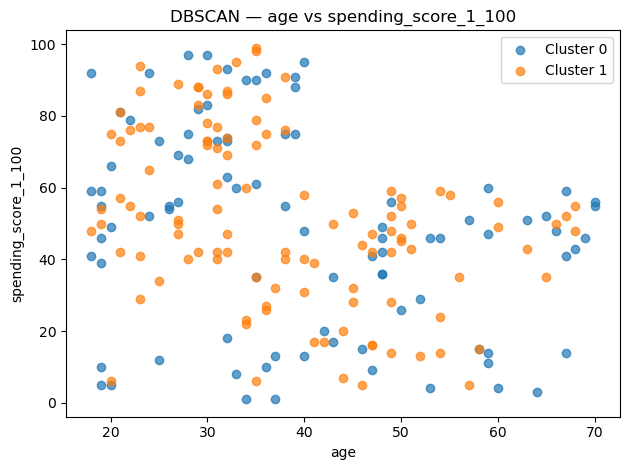

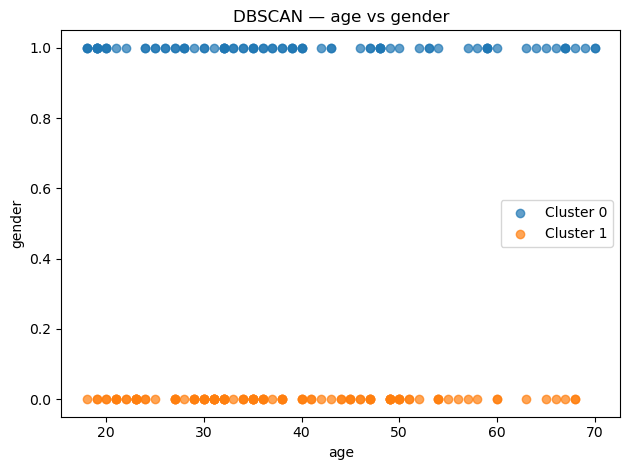

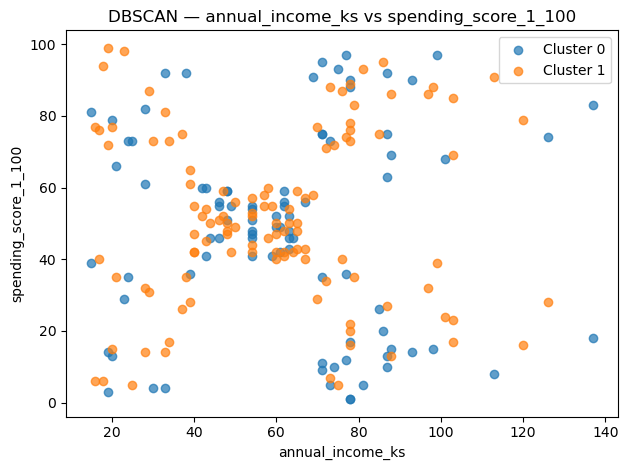

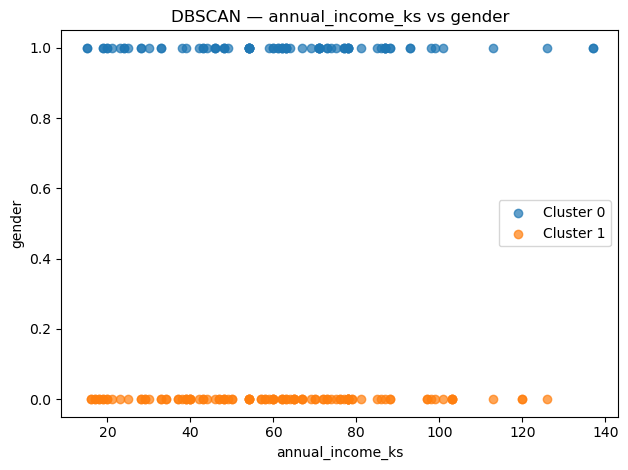

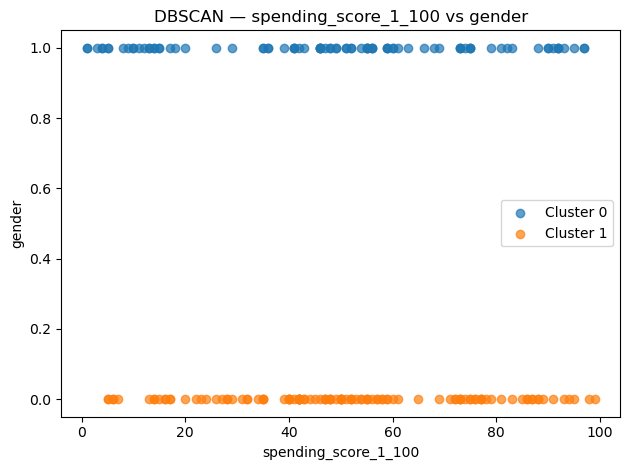

In [34]:
if best_labels is not None:
    df["dbscan_cluster"] = best_labels
    # 2D plots for DBSCAN on the same pairs
    for xcol, ycol in pairs:
        plt.figure()
        for cl in sorted(set(best_labels)):
            mask = best_labels == cl
            plt.scatter(df.loc[mask, xcol], df.loc[mask, ycol], alpha=0.7, label=f"Cluster {cl}")
        plt.title(f"DBSCAN — {xcol} vs {ycol}")
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.legend()
        plt.tight_layout()
        plt.show()

## Conclusions and Insights:

In this project, we successfully applied unsupervised learning (clustering) to segment mall customers based on their age, annual income, and spending score.

- **Data Exploration**: Histograms and scatterplots revealed natural groupings and variations in customer demographics and spending habits.

- **Clustering with K-Means**: Using the Elbow method and Silhouette score, we identified an optimal number of clusters. These clusters represent distinct customer groups with unique spending and income patterns.

- **Cluster Profiling**: By analyzing the average age, income, and spending score in each cluster, we gained insights into different customer types, such as high-income high-spending customers, budget-conscious customers, and young low-spending customers.

- **Average Spending**: The comparison of average spending across clusters highlighted the most valuable customer segments for targeted marketing strategies.

- DBSCAN: We also experimented with DBSCAN, which can discover clusters of arbitrary shapes. While more sensitive to parameter tuning, it provided an alternative perspective on the dataset.